<a href="https://colab.research.google.com/github/cal-wells/sql-python-projects/blob/main/First_to_Fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First to Fast Data Analysis

*Analysis of First to Fast 10K Data*

**Source:** [Data](https://results.racetimingsolutions.co.uk/results.aspx?CId=16269&RId=24016&EId=4&dt=0&adv=1)

---

## Retrieve Data from Github and create SQL Database

---

In [ ]:
# Libraries
import sqlite3
import pandas as pd

# Github URL prefix
url_prefix = "https://raw.githubusercontent.com/cal-wells/sql-python-projects/refs/heads/main/First%20to%20Fast/Wave_"

# Create a connection to database
conn = sqlite3.connect("first_2_fast.db")

# Loop to get three dataframes for each wave
for wave_num in range(1, 4):
    url = f"{url_prefix}{wave_num}.csv"
    df_name = f"df_wave_{wave_num}"
    try:
        globals()[df_name] = pd.read_csv(url, encoding='utf-16', encoding_errors='ignore')
        print(f"Loaded {df_name} from {url}")
        # Save each dataframe to the database here
        globals()[df_name].to_sql(f"wave_{wave_num}", conn, if_exists="replace", index=False)
    except Exception as e:
        print(f"Error loading {df_name} from {url}: {e}")

Loaded df_wave_1 from https://raw.githubusercontent.com/cal-wells/sql-python-projects/refs/heads/main/First%20to%20Fast/Wave_1.csv
Loaded df_wave_2 from https://raw.githubusercontent.com/cal-wells/sql-python-projects/refs/heads/main/First%20to%20Fast/Wave_2.csv
Loaded df_wave_3 from https://raw.githubusercontent.com/cal-wells/sql-python-projects/refs/heads/main/First%20to%20Fast/Wave_3.csv


## Import Packages and Custom Fonts for Visualisations

---



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

# Add the custom fonts
font_path_regular = '/content/drive/MyDrive/Colab Notebooks/Fonts/MonaSans/MonaSans-Regular.ttf'
font_path_bold = '/content/drive/MyDrive/Colab Notebooks/Fonts/MonaSans/MonaSans-Bold.ttf'
font_path_italic = '/content/drive/MyDrive/Colab Notebooks/Fonts/MonaSans/MonaSans-Italic.ttf'

fm.fontManager.addfont(font_path_regular)
fm.fontManager.addfont(font_path_bold)

## Wave 1 Analysis

Importing Data from Wave 1 and producing some visualisations

---

### Import Data from SQL and Clean

In [ ]:
# Define the SQL query as a variable
w1_query = """
           SELECT
            "Net Pos",
            "Name",
            "Net Time",
            "Category"
           FROM
            wave_1
           """
# Read data from the wave_1 table into a DataFrame with selected columns using the query variable
df_w1_db = pd.read_sql_query(w1_query, conn)

In [ ]:
# Remove rows where 'Net Pos' or 'Category' is null
df_w1_clean = df_w1_db.dropna(subset=['Net Pos', 'Category'])

# Convert 'Net Time' to timedelta objects
df_w1_clean['Net Time'] = pd.to_timedelta(df_w1_clean['Net Time'])

# Convert timedelta to total seconds
df_w1_clean['Net Time Seconds'] = df_w1_clean['Net Time'].dt.total_seconds()

/tmp/ipython-input-1605192052.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w1_clean['Net Time'] = pd.to_timedelta(df_w1_clean['Net Time'])
/tmp/ipython-input-1605192052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w1_clean['Net Time Seconds'] = df_w1_clean['Net Time'].dt.total_seconds()


In [ ]:
df_w1_clean.head()

,Net Pos,Name,Net Time,Category,Net Time Seconds
0,1.0,Michael Jones,0 days 00:37:12,18 - 34,2232.0
1,2.0,Henry Holt,0 days 00:38:34,18 - 34,2314.0
2,3.0,Sam Campbell,0 days 00:38:50,18 - 34,2330.0
3,4.0,Miles Alexander,0 days 00:38:52,18 - 34,2332.0
4,5.0,Charlie Shoebridge,0 days 00:38:58,18 - 34,2338.0


### Table Visualisation for Summary Statistics

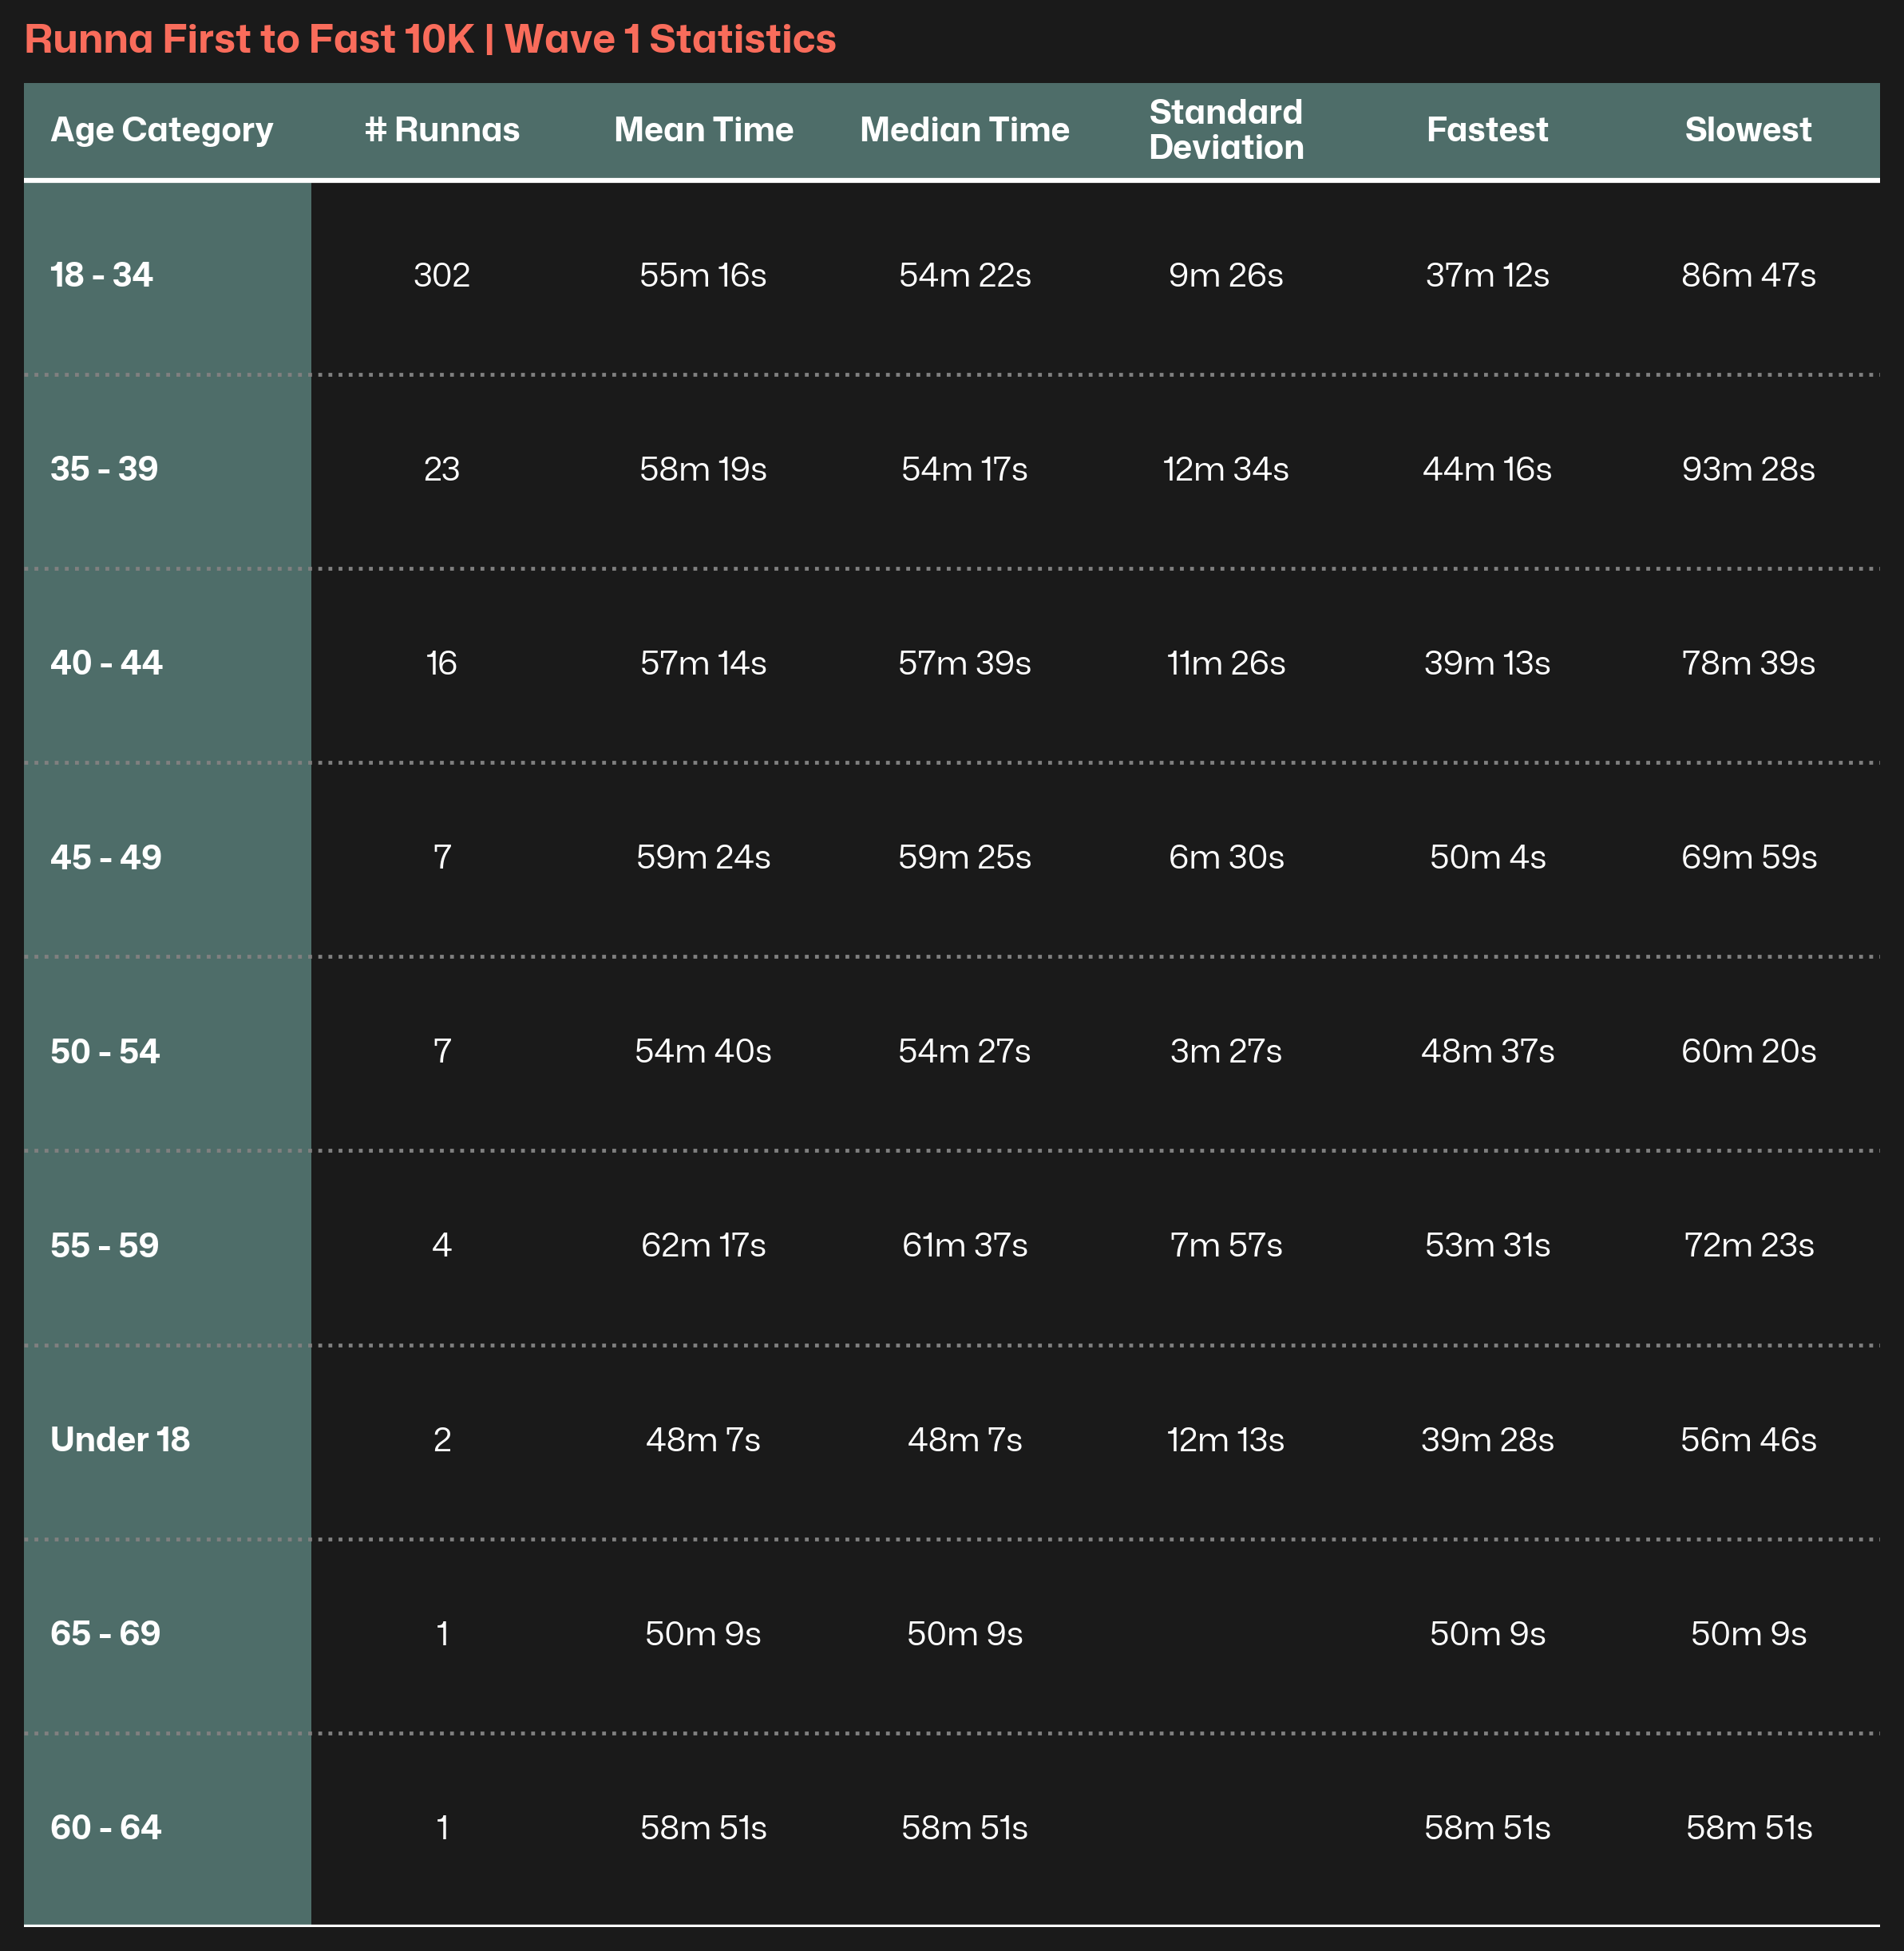

In [ ]:
# Calculate summary statistics for 'Net Time Seconds' by 'Category'
# Group the data by 'Category' and calculate count, mean, median, standard deviation, min, and max of 'Net Time Seconds'
summary_stats = df_w1_clean.groupby('Category')['Net Time Seconds'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()

# Function to format seconds into minutes and seconds
def format_seconds_series(series):
    return series.apply(lambda x: f"{int(x // 60)}m {int(x % 60)}s" if pd.notnull(x) else '')

# Apply the time formatting function to the summary statistics columns
summary_stats['mean'] = format_seconds_series(summary_stats['mean'])
summary_stats['median'] = format_seconds_series(summary_stats['median'])
summary_stats['std'] = format_seconds_series(summary_stats['std'])
summary_stats['min'] = format_seconds_series(summary_stats['min'])
summary_stats['max'] = format_seconds_series(summary_stats['max'])
# Sort the summary statistics by the count of participants in each category
summary_stats.sort_values(by='count', inplace=True)

# Create a figure and axes for the table
fig = plt.figure(figsize=(10,10), dpi=300)
ax = plt.subplot()

# Define the number of columns and rows for the table
ncols = 7
nrows = summary_stats.shape[0]

# Set the limits for the axes to accommodate the table
ax.set_xlim(0, ncols + .1)
ax.set_ylim(0, nrows + .5)

# Define the positions for each column in the table
positions = [0.1, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
# Define the columns to display from the summary_stats DataFrame
columns = ['Category', 'count', 'mean', 'median', 'std', 'min', 'max']

# Set facecolor of the figure and axes
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')

# Add table's main text (data rows)
for i in range(nrows):
    for j, column in enumerate(columns):
        # Set horizontal alignment for the text
        if j == 0:
            ha = 'left'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to bold for the first column (Category)
            weight = 'bold'
            # Set font properties for the bold text
            font_properties = fm.FontProperties(fname=font_path_bold)
        else:
            ha = 'center'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to normal for other columns
            weight = 'normal'
            # Set font properties for the regular text
            font_properties = fm.FontProperties(fname=font_path_regular)
        # Add the text annotation to the plot
        ax.annotate(
            xy=(positions[j], i + .5), # Position of the annotation
            text=text_label, # The text to display
            ha=ha, # Horizontal alignment
            weight=weight, # Font weight
            va='center', # Vertical alignment
            color='white', # Set font color to white
            fontproperties=font_properties # Font properties
        )

# Add column names (header row)
column_names = ['Age Category', '# Runnas', 'Mean Time', 'Median Time', 'Standard\nDeviation', 'Fastest', 'Slowest']
for index, c in enumerate(column_names):
        # Set horizontal alignment for the column names
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        # Add the column name annotation to the plot
        ax.annotate(
            xy=(positions[index], nrows + .25), # Position of the annotation
            text=column_names[index], # The text to display (column name)
            ha=ha, # Horizontal alignment
            va='center', # Vertical alignment
            weight='bold', # Font weight for column names
            color='white', # Set font color to white
            fontproperties=fm.FontProperties(fname=font_path_bold) # Font properties for bold text
        )

# Add dividing lines to the table
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='white', marker='', zorder=4) # Top line
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='white', marker='', zorder=4) # Bottom line
# Add horizontal lines for each row
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

# Add shaded regions to the table
ax.fill_between(
    x=[0,1.1],
    y1=nrows,
    y2=0,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

ax.fill_between(
    x=[0,ncols + 0.1],
    y1=nrows + 1,
    y2=nrows,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

# Add the title to the figure
fig.text(
    x=0.125, y=0.89,
    s='Runna First to Fast 10K | Wave 1 Statistics',
    ha='left',
    va='bottom',
    weight='bold',
    size=12,
    color='#f96c5b',
    fontproperties=fm.FontProperties(fname=font_path_bold)
)

# Turn off the axes
ax.set_axis_off()

### Swarm Plot for All Age Categories

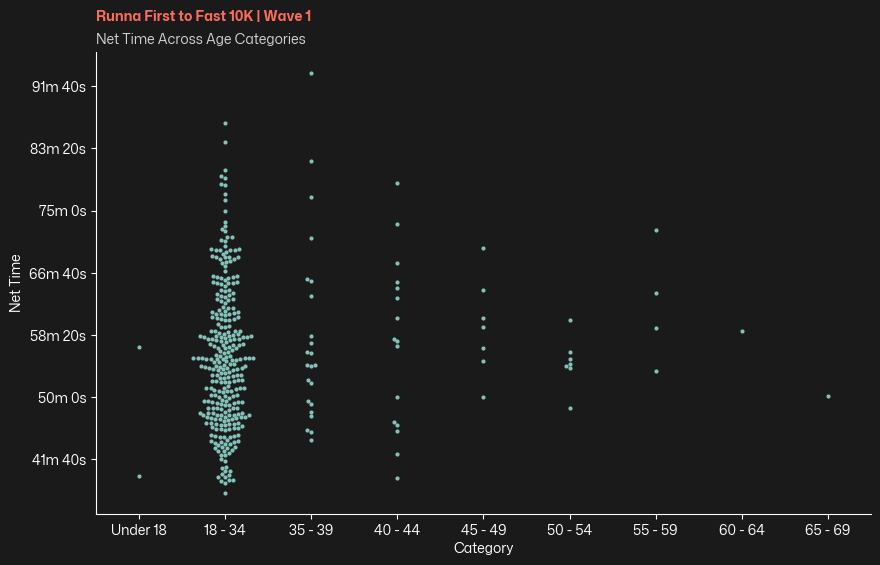

In [ ]:
# Create a swarm plot of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
# Define the desired order of categories
category_order = ['Under 18', '18 - 34', '35 - 39', '40 - 44', '45 - 49', '50 - 54', '55 - 59', '60 - 64', '65 - 69']
sns.swarmplot(data=df_w1_clean, y='Net Time Seconds', x='Category', ax=ax, color='#82c0b8', size=3, order=category_order)

# Function to format seconds into minutes and seconds
def seconds_to_minutes_seconds(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f"{minutes}m {seconds}s"

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | Wave 1', x=0.233, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time Across Age Categories', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.ylabel('Net Time', color='white')
plt.xlabel('Category', color='white') # Remove x-axis label for swarm plot
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='x', colors='white')

# Apply the formatter to the y-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().yaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

plt.show()

### Histogram for 18 - 34 Age Category

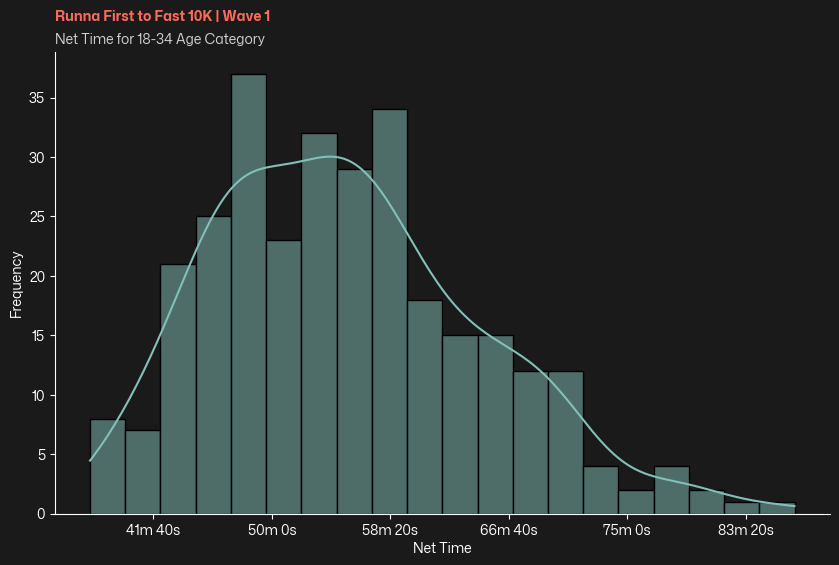

In [ ]:
# Filter the DataFrame for the '18 - 34' category
df_18_34 = df_w1_clean[df_w1_clean['Category'] == '18 - 34'].copy()

# Create a histogram of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
sns.histplot(data=df_18_34, x='Net Time Seconds', bins=20, kde=True, ax=ax, color='#82c0b8')

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | Wave 1', x=0.233, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time for 18-34 Age Category', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.xlabel('Net Time', color='white')
plt.ylabel('Frequency', color='white')
# plt.grid(axis='y', alpha=0.75) # Remove gridlines
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Apply the formatter to the x-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().xaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

plt.show()

## Wave 2 Analysis

Importing Data from Wave 2 and producing some visualisations

---

### Import Data from SQL and Clean

In [ ]:
# Define the SQL query as a variable
w2_query = """
           SELECT
            "Net Pos",
            "Name",
            "Net Time",
            "Category"
           FROM
            wave_2
           """
# Read data from the wave_2 table into a DataFrame with selected columns using the query variable
df_w2_db = pd.read_sql_query(w2_query, conn)

In [ ]:
# Remove rows where 'Net Pos' or 'Category' is null
df_w2_clean = df_w2_db.dropna(subset=['Net Pos', 'Category'])

# Filter the data to exclude rows where 'Category' is 'Unknown'
df_w2_clean = df_w2_clean[df_w2_clean["Category"] != "Unknown"]
df_w2_clean.sort_values(by="Net Pos", inplace=True)

# Convert 'Net Time' to timedelta objects
df_w2_clean['Net Time'] = pd.to_timedelta(df_w2_clean['Net Time'])

# Convert timedelta to total seconds
df_w2_clean['Net Time Seconds'] = df_w2_clean['Net Time'].dt.total_seconds()

# Reset index and show head
df_w2_clean.reset_index(drop=True, inplace=True)
df_w2_clean.head()

,Net Pos,Name,Net Time,Category,Net Time Seconds
0,1.0,Rebekah Leo,0 days 00:36:10,18 - 34,2170.0
1,3.0,Ryder King,0 days 00:36:18,18 - 34,2178.0
2,5.0,Rob Green,0 days 00:37:00,18 - 34,2220.0
3,7.0,Ben Main,0 days 00:37:23,18 - 34,2243.0
4,9.0,Russ Cook,0 days 00:37:23,18 - 34,2243.0


### Table Visualisation for Summary Statistics

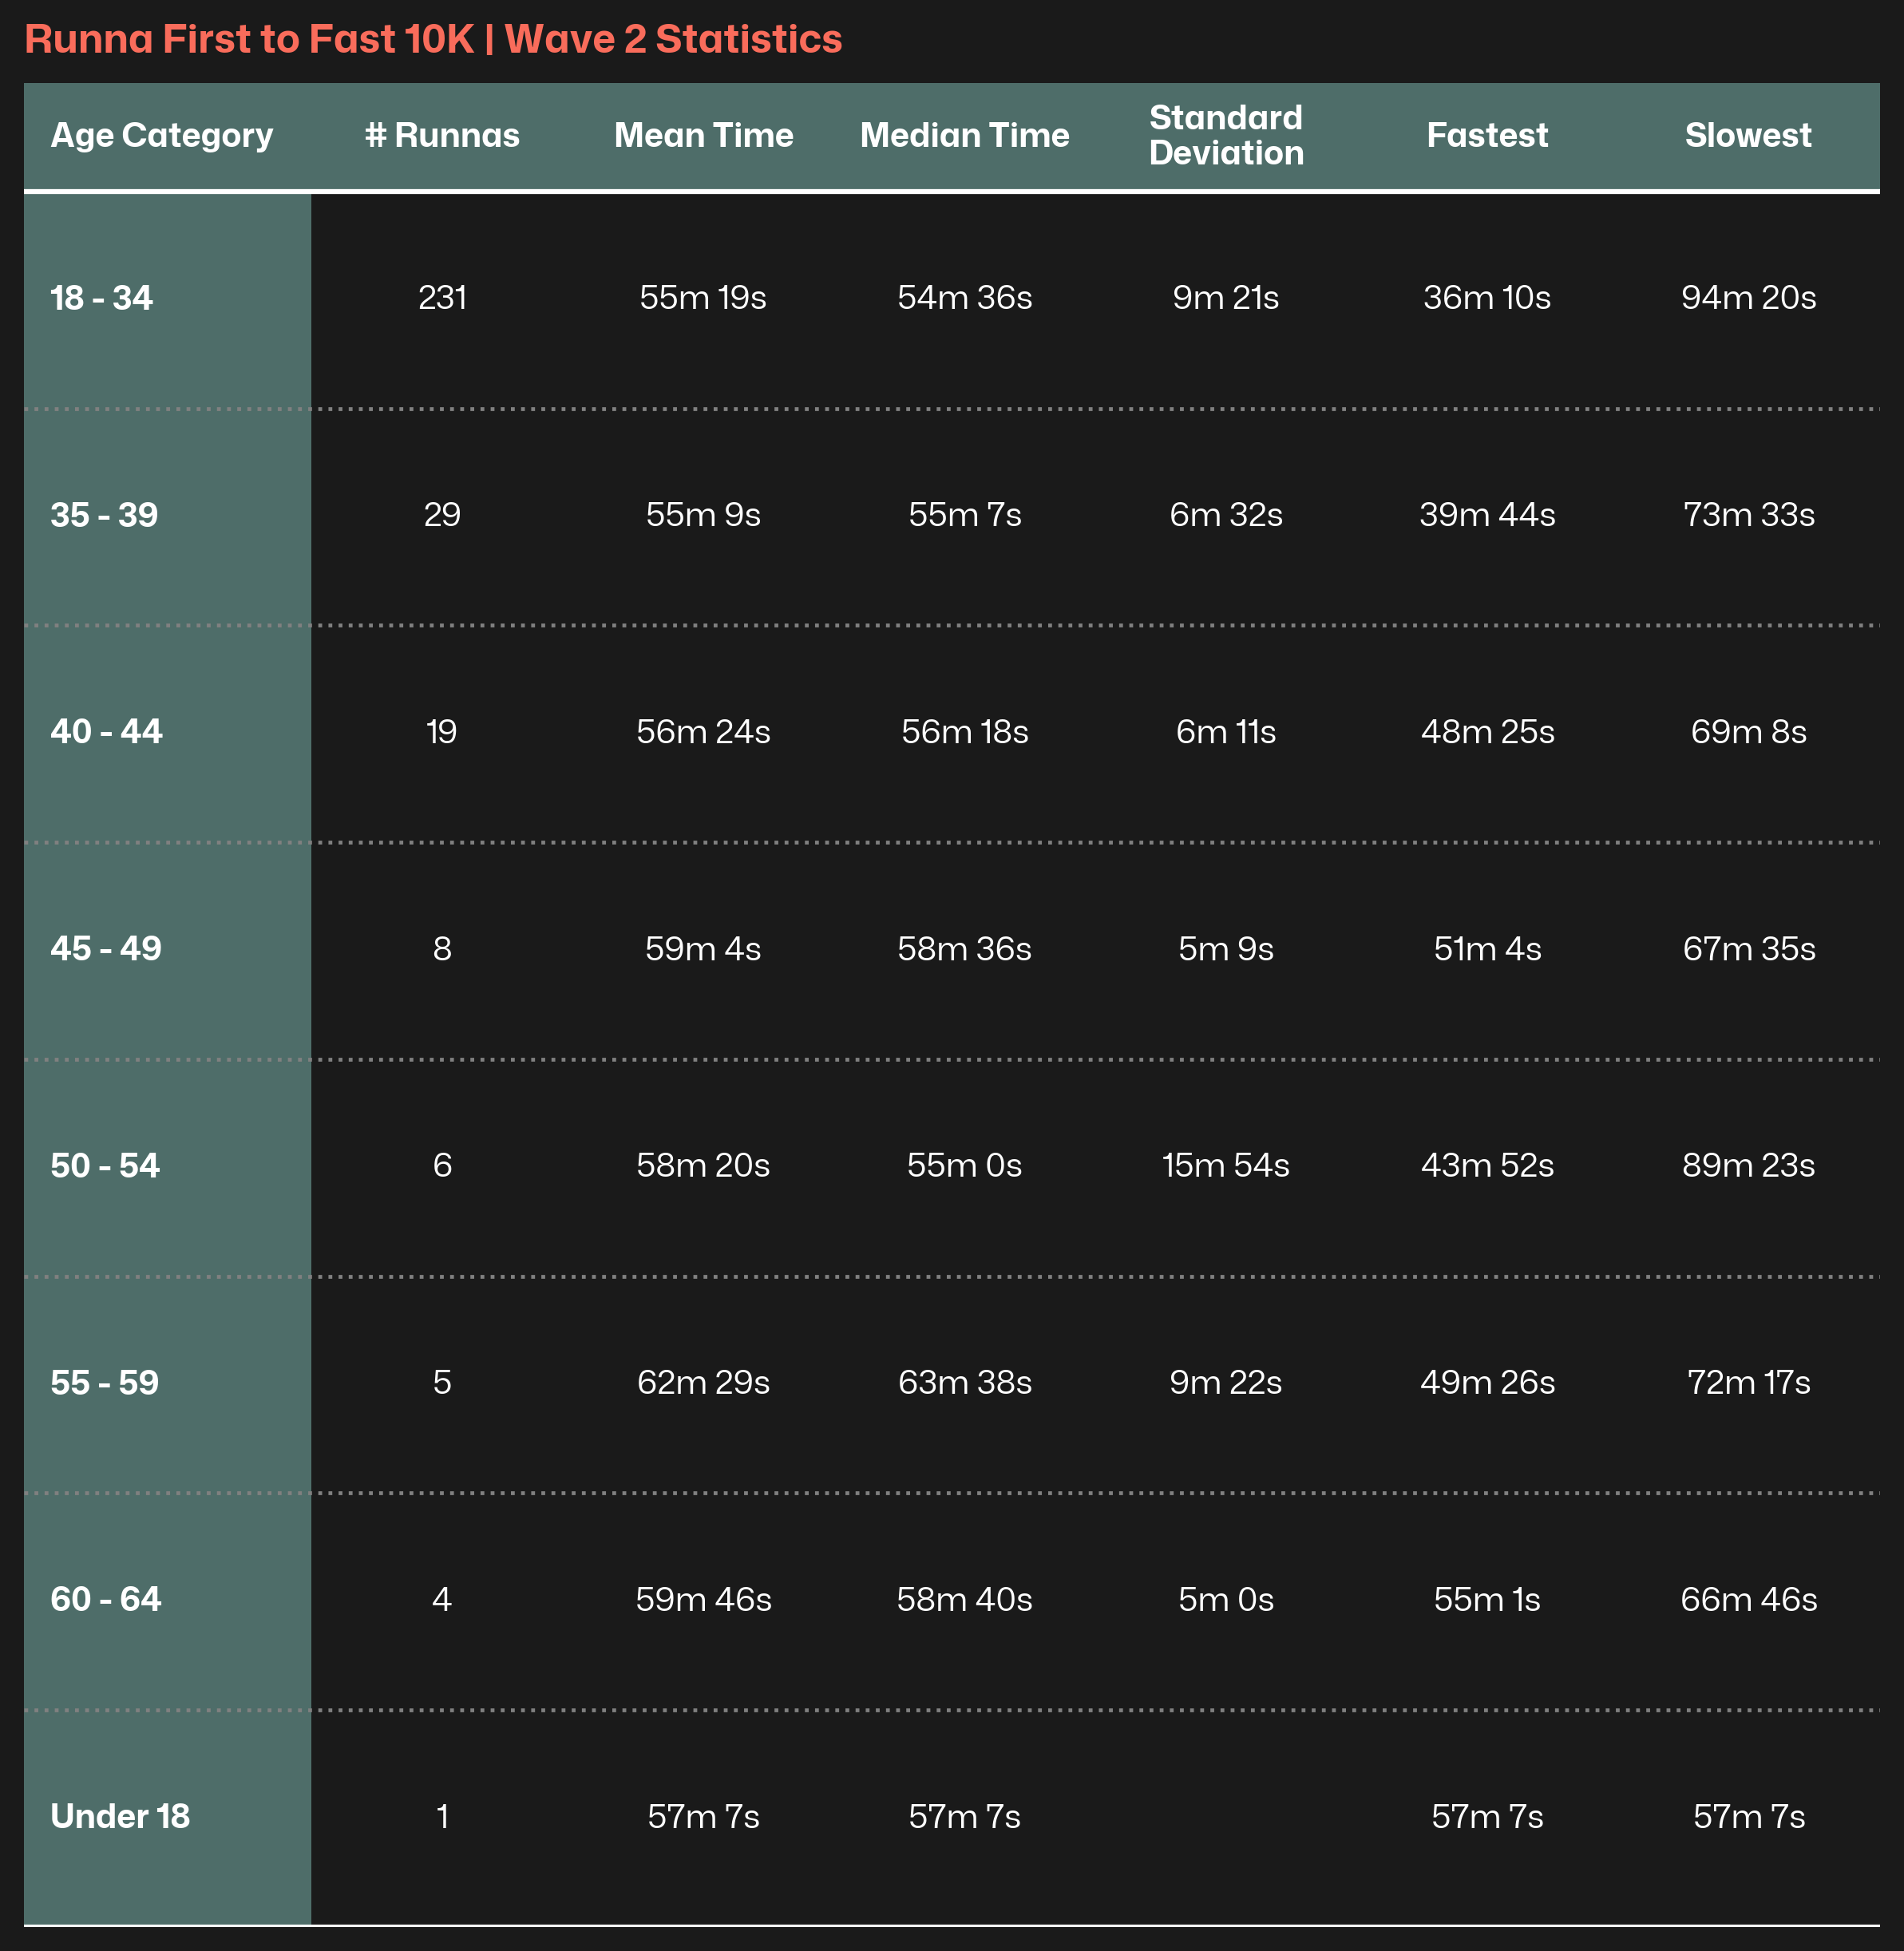

In [ ]:
# Calculate summary statistics for 'Net Time Seconds' by 'Category'
# Group the data by 'Category' and calculate count, mean, median, standard deviation, min, and max of 'Net Time Seconds'
summary_stats = df_w2_clean.groupby('Category')['Net Time Seconds'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()

# Function to format seconds into minutes and seconds
def format_seconds_series(series):
    return series.apply(lambda x: f"{int(x // 60)}m {int(x % 60)}s" if pd.notnull(x) else '')

# Apply the time formatting function to the summary statistics columns
summary_stats['mean'] = format_seconds_series(summary_stats['mean'])
summary_stats['median'] = format_seconds_series(summary_stats['median'])
summary_stats['std'] = format_seconds_series(summary_stats['std'])
summary_stats['min'] = format_seconds_series(summary_stats['min'])
summary_stats['max'] = format_seconds_series(summary_stats['max'])
# Sort the summary statistics by the count of participants in each category
summary_stats.sort_values(by='count', inplace=True)

# Create a figure and axes for the table
fig = plt.figure(figsize=(10,10), dpi=300)
ax = plt.subplot()

# Define the number of columns and rows for the table
ncols = 7
nrows = summary_stats.shape[0]

# Set the limits for the axes to accommodate the table
ax.set_xlim(0, ncols + .1)
ax.set_ylim(0, nrows + .5)

# Define the positions for each column in the table
positions = [0.1, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
# Define the columns to display from the summary_stats DataFrame
columns = ['Category', 'count', 'mean', 'median', 'std', 'min', 'max']

# Set facecolor of the figure and axes
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')

# Add table's main text (data rows)
for i in range(nrows):
    for j, column in enumerate(columns):
        # Set horizontal alignment for the text
        if j == 0:
            ha = 'left'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to bold for the first column (Category)
            weight = 'bold'
            # Set font properties for the bold text
            font_properties = fm.FontProperties(fname=font_path_bold)
        else:
            ha = 'center'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to normal for other columns
            weight = 'normal'
            # Set font properties for the regular text
            font_properties = fm.FontProperties(fname=font_path_regular)
        # Add the text annotation to the plot
        ax.annotate(
            xy=(positions[j], i + .5), # Position of the annotation
            text=text_label, # The text to display
            ha=ha, # Horizontal alignment
            weight=weight, # Font weight
            va='center', # Vertical alignment
            color='white', # Set font color to white
            fontproperties=font_properties # Font properties
        )

# Add column names (header row)
column_names = ['Age Category', '# Runnas', 'Mean Time', 'Median Time', 'Standard\nDeviation', 'Fastest', 'Slowest']
for index, c in enumerate(column_names):
        # Set horizontal alignment for the column names
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        # Add the column name annotation to the plot
        ax.annotate(
            xy=(positions[index], nrows + .25), # Position of the annotation
            text=column_names[index], # The text to display (column name)
            ha=ha, # Horizontal alignment
            va='center', # Vertical alignment
            weight='bold', # Font weight for column names
            color='white', # Set font color to white
            fontproperties=fm.FontProperties(fname=font_path_bold) # Font properties for bold text
        )

# Add dividing lines to the table
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='white', marker='', zorder=4) # Top line
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='white', marker='', zorder=4) # Bottom line
# Add horizontal lines for each row
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

# Add shaded regions to the table
ax.fill_between(
    x=[0,1.1],
    y1=nrows,
    y2=0,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

ax.fill_between(
    x=[0,ncols + 0.1],
    y1=nrows + 1,
    y2=nrows,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

# Add the title to the figure
fig.text(
    x=0.125, y=0.89,
    s='Runna First to Fast 10K | Wave 2 Statistics',
    ha='left',
    va='bottom',
    weight='bold',
    size=12,
    color='#f96c5b',
    fontproperties=fm.FontProperties(fname=font_path_bold)
)

# Turn off the axes
ax.set_axis_off()

### Swarm Plot for All Age Categories

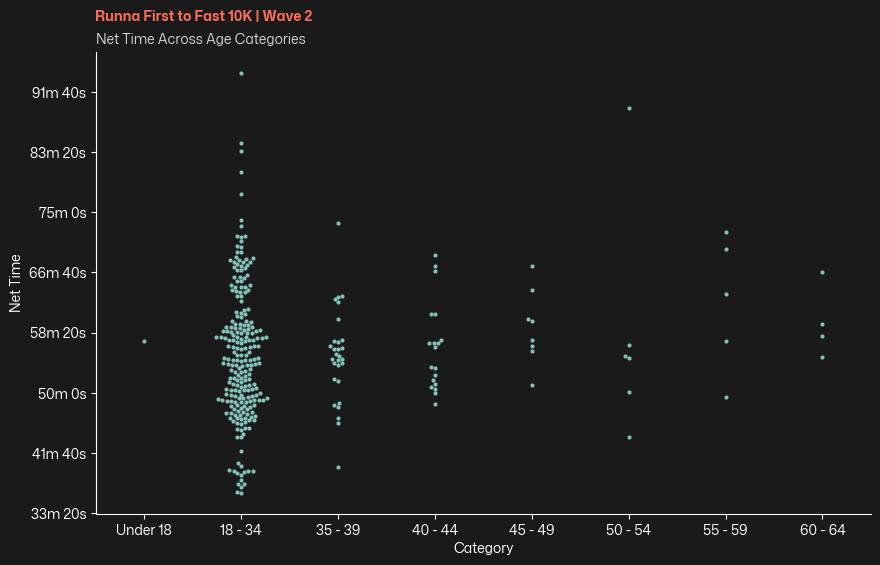

In [ ]:
# Create a swarm plot of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
# Define the desired order of categories
category_order = ['Under 18', '18 - 34', '35 - 39', '40 - 44', '45 - 49', '50 - 54', '55 - 59', '60 - 64']
sns.swarmplot(data=df_w2_clean, y='Net Time Seconds', x='Category', ax=ax, color='#82c0b8', size=3, order=category_order)

# Function to format seconds into minutes and seconds
def seconds_to_minutes_seconds(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f"{minutes}m {seconds}s"

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | Wave 2', x=0.233, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time Across Age Categories', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.ylabel('Net Time', color='white')
plt.xlabel('Category', color='white') # Remove x-axis label for swarm plot
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='x', colors='white')

# Apply the formatter to the y-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().yaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

plt.show()

### Histogram for 18 - 34 Age Category

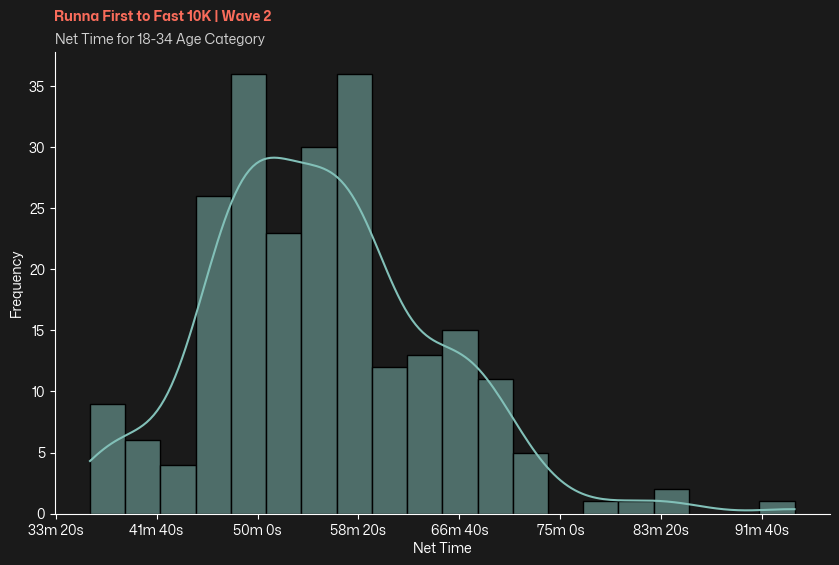

In [ ]:
# Filter the DataFrame for the '18 - 34' category
df_18_34_w2 = df_w2_clean[df_w2_clean['Category'] == '18 - 34'].copy()

# Create a histogram of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
sns.histplot(data=df_18_34_w2, x='Net Time Seconds', bins=20, kde=True, ax=ax, color='#82c0b8')

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | Wave 2', x=0.233, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time for 18-34 Age Category', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.xlabel('Net Time', color='white')
plt.ylabel('Frequency', color='white')
# plt.grid(axis='y', alpha=0.75) # Remove gridlines
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Apply the formatter to the x-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().xaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

plt.show()

## Wave 3 Analysis

Importing Data from Wave 3 and producing some visualisations

---

### Import Data from SQL and Clean

In [ ]:
# Define the SQL query as a variable
w3_query = """
           SELECT
            "Net Pos",
            "Name",
            "Net Time",
            "Category"
           FROM
            wave_3
           """
# Read data from the wave_3 table into a DataFrame with selected columns using the query variable
df_w3_db = pd.read_sql_query(w3_query, conn)

In [ ]:
# Remove rows where 'Net Pos' or 'Category' is null
df_w3_clean = df_w3_db.dropna(subset=['Net Pos', 'Category'])

# Filter the data to exclude rows where 'Category' is 'Unknown'
df_w3_clean = df_w3_clean[df_w3_clean["Category"] != "Unknown"]
df_w3_clean.sort_values(by="Net Pos", inplace=True)

# Convert 'Net Time' to timedelta objects
df_w3_clean['Net Time'] = pd.to_timedelta(df_w3_clean['Net Time'])

# Convert timedelta to total seconds
df_w3_clean['Net Time Seconds'] = df_w3_clean['Net Time'].dt.total_seconds()

# Reset index and show head
df_w3_clean.reset_index(drop=True, inplace=True)
df_w3_clean.head()

,Net Pos,Name,Net Time,Category,Net Time Seconds
0,1.0,Joe Wigfield,0 days 00:29:20,18 - 34,1760.0
1,2.0,Jacob Allen,0 days 00:29:25,18 - 34,1765.0
2,3.0,Samuel Stevens,0 days 00:31:40,18 - 34,1900.0
3,4.0,Raif Serif,0 days 00:32:14,18 - 34,1934.0
4,5.0,Harry Tivnen,0 days 00:32:50,18 - 34,1970.0


### Table Visualisation for Summary Statistics

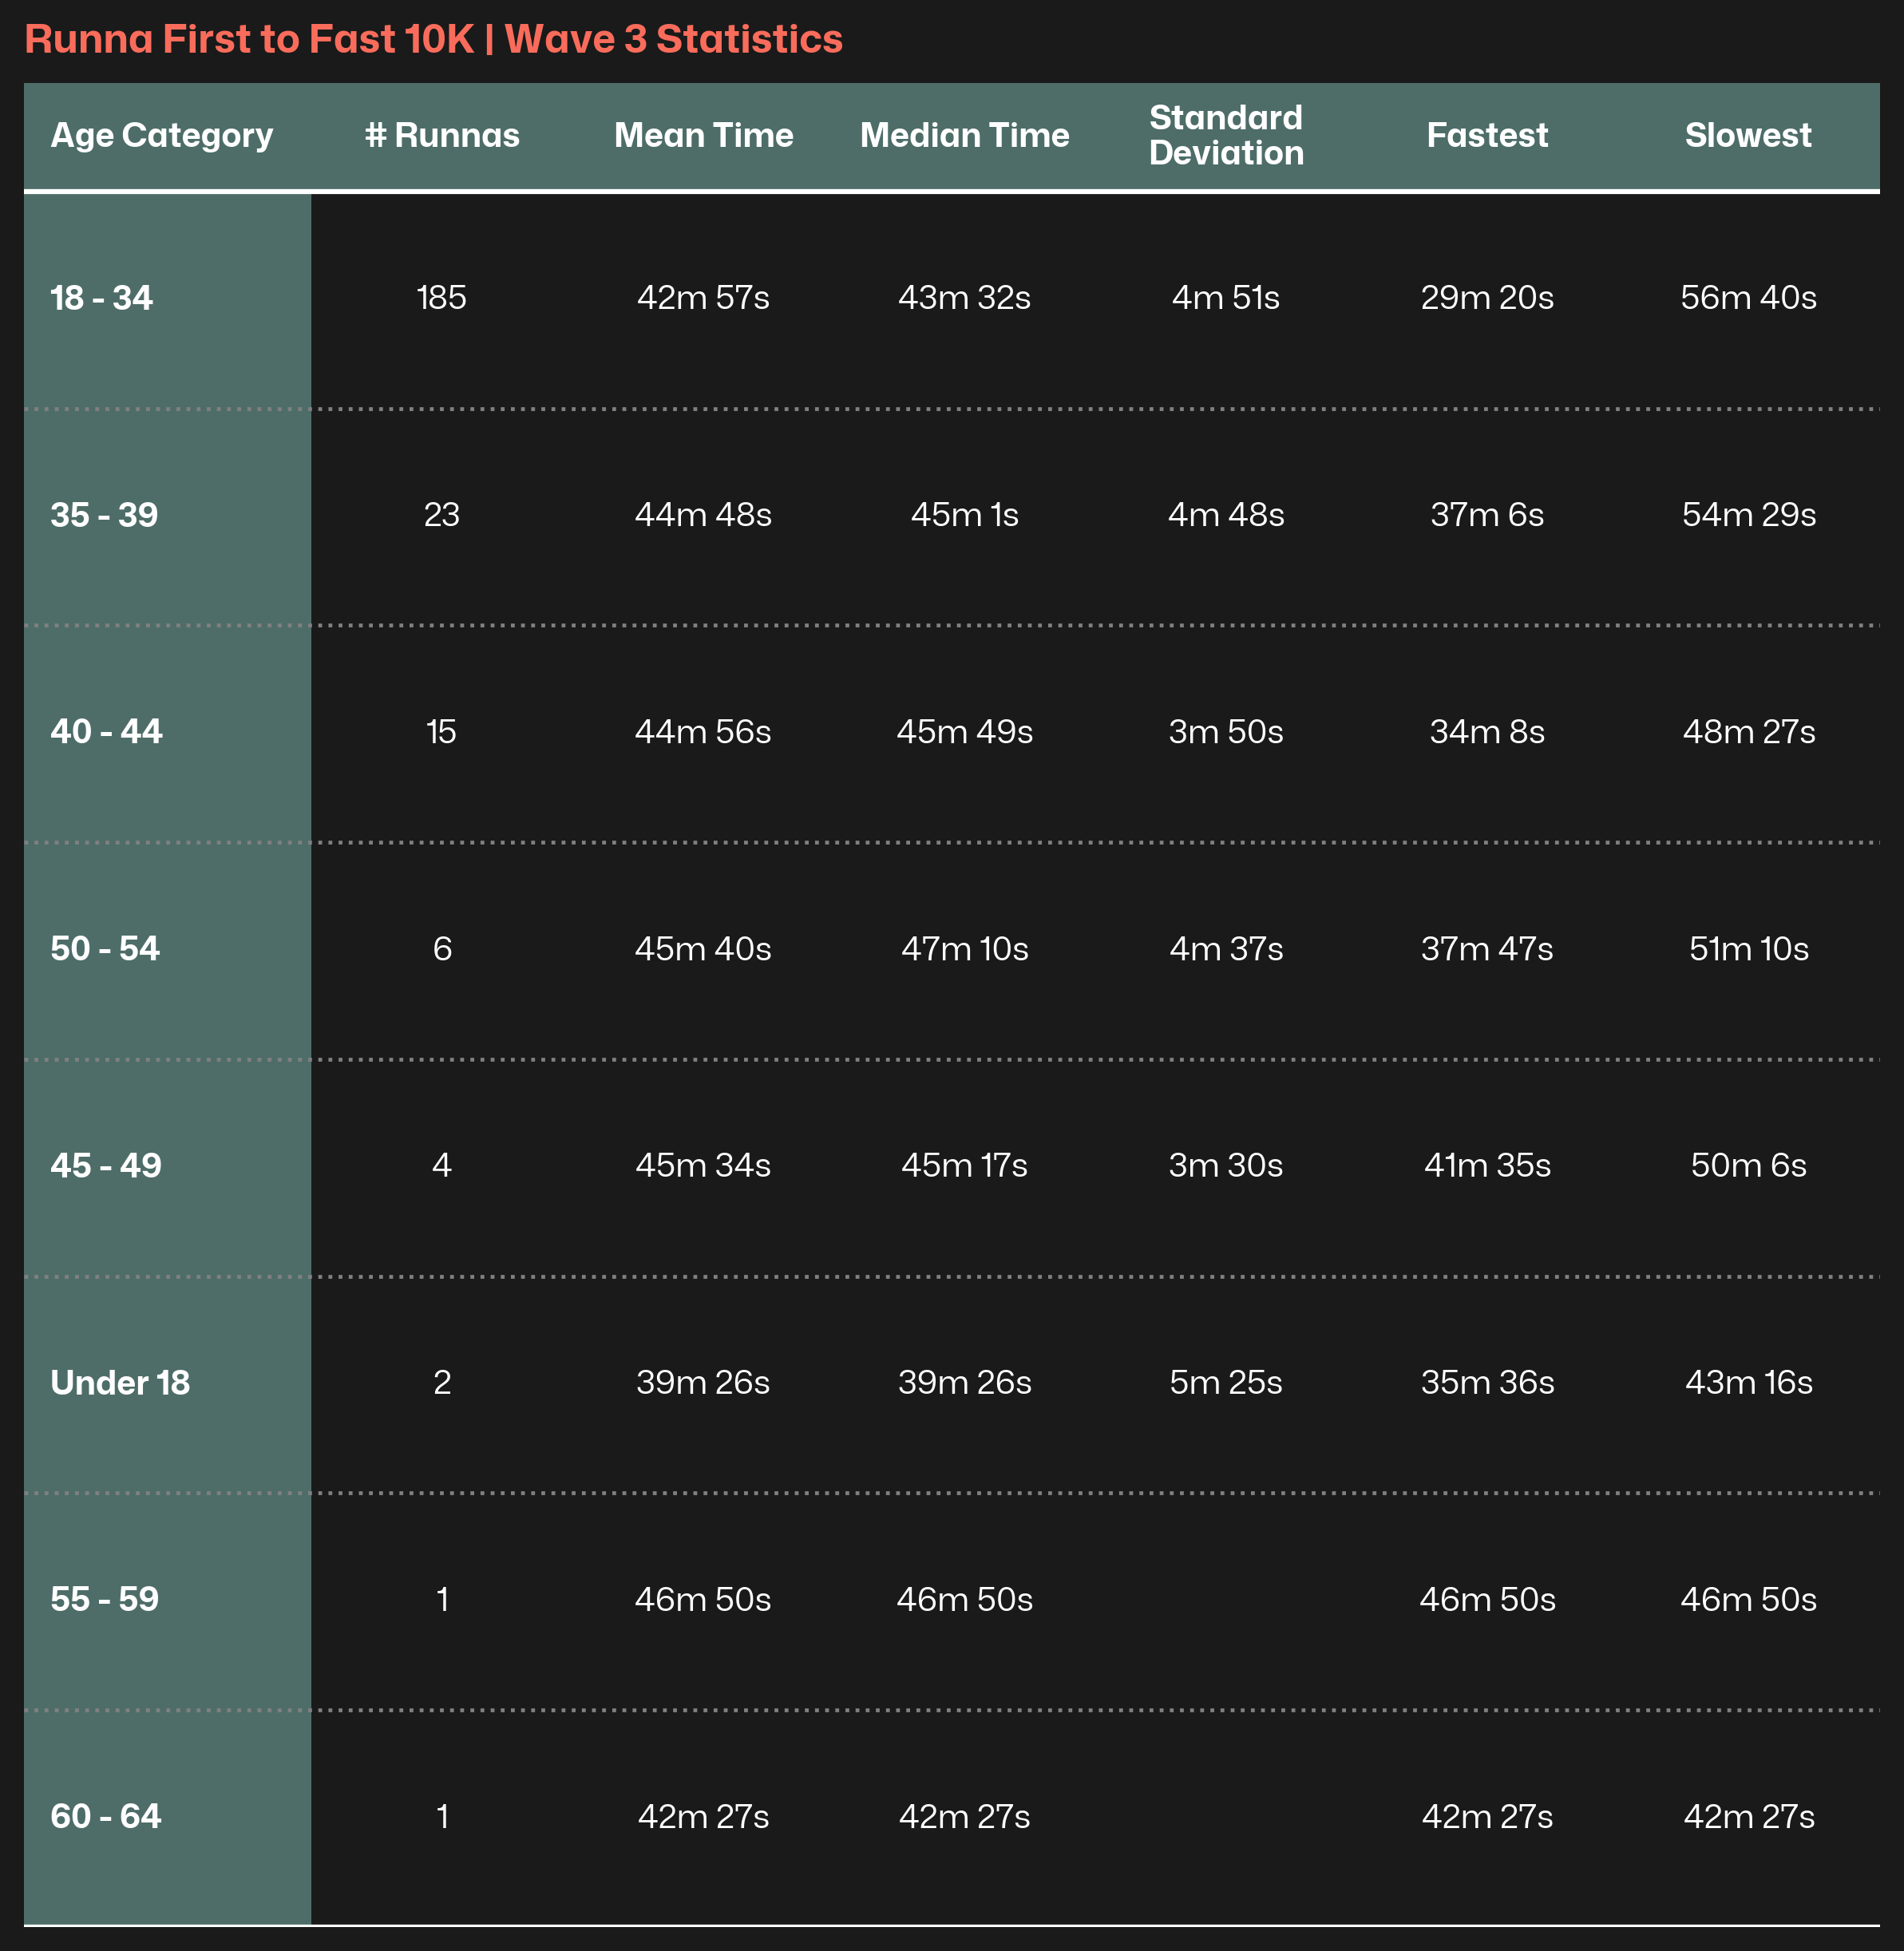

In [ ]:
# Calculate summary statistics for 'Net Time Seconds' by 'Category'
# Group the data by 'Category' and calculate count, mean, median, standard deviation, min, and max of 'Net Time Seconds'
summary_stats = df_w3_clean.groupby('Category')['Net Time Seconds'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()

# Function to format seconds into minutes and seconds
def format_seconds_series(series):
    return series.apply(lambda x: f"{int(x // 60)}m {int(x % 60)}s" if pd.notnull(x) else '')

# Apply the time formatting function to the summary statistics columns
summary_stats['mean'] = format_seconds_series(summary_stats['mean'])
summary_stats['median'] = format_seconds_series(summary_stats['median'])
summary_stats['std'] = format_seconds_series(summary_stats['std'])
summary_stats['min'] = format_seconds_series(summary_stats['min'])
summary_stats['max'] = format_seconds_series(summary_stats['max'])
# Sort the summary statistics by the count of participants in each category
summary_stats.sort_values(by='count', inplace=True)

# Create a figure and axes for the table
fig = plt.figure(figsize=(10,10), dpi=300)
ax = plt.subplot()

# Define the number of columns and rows for the table
ncols = 7
nrows = summary_stats.shape[0]

# Set the limits for the axes to accommodate the table
ax.set_xlim(0, ncols + .1)
ax.set_ylim(0, nrows + .5)

# Define the positions for each column in the table
positions = [0.1, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
# Define the columns to display from the summary_stats DataFrame
columns = ['Category', 'count', 'mean', 'median', 'std', 'min', 'max']

# Set facecolor of the figure and axes
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')

# Add table's main text (data rows)
for i in range(nrows):
    for j, column in enumerate(columns):
        # Set horizontal alignment for the text
        if j == 0:
            ha = 'left'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to bold for the first column (Category)
            weight = 'bold'
            # Set font properties for the bold text
            font_properties = fm.FontProperties(fname=font_path_bold)
        else:
            ha = 'center'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to normal for other columns
            weight = 'normal'
            # Set font properties for the regular text
            font_properties = fm.FontProperties(fname=font_path_regular)
        # Add the text annotation to the plot
        ax.annotate(
            xy=(positions[j], i + .5), # Position of the annotation
            text=text_label, # The text to display
            ha=ha, # Horizontal alignment
            weight=weight, # Font weight
            va='center', # Vertical alignment
            color='white', # Set font color to white
            fontproperties=font_properties # Font properties
        )

# Add column names (header row)
column_names = ['Age Category', '# Runnas', 'Mean Time', 'Median Time', 'Standard\nDeviation', 'Fastest', 'Slowest']
for index, c in enumerate(column_names):
        # Set horizontal alignment for the column names
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        # Add the column name annotation to the plot
        ax.annotate(
            xy=(positions[index], nrows + .25), # Position of the annotation
            text=column_names[index], # The text to display (column name)
            ha=ha, # Horizontal alignment
            va='center', # Vertical alignment
            weight='bold', # Font weight for column names
            color='white', # Set font color to white
            fontproperties=fm.FontProperties(fname=font_path_bold) # Font properties for bold text
        )

# Add dividing lines to the table
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='white', marker='', zorder=4) # Top line
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='white', marker='', zorder=4) # Bottom line
# Add horizontal lines for each row
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

# Add shaded regions to the table
ax.fill_between(
    x=[0,1.1],
    y1=nrows,
    y2=0,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

ax.fill_between(
    x=[0,ncols + 0.1],
    y1=nrows + 1,
    y2=nrows,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

# Add the title to the figure
fig.text(
    x=0.125, y=0.89,
    s='Runna First to Fast 10K | Wave 3 Statistics',
    ha='left',
    va='bottom',
    weight='bold',
    size=12,
    color='#f96c5b',
    fontproperties=fm.FontProperties(fname=font_path_bold)
)

# Turn off the axes
ax.set_axis_off()

### Swarm Plot for All Age Categories

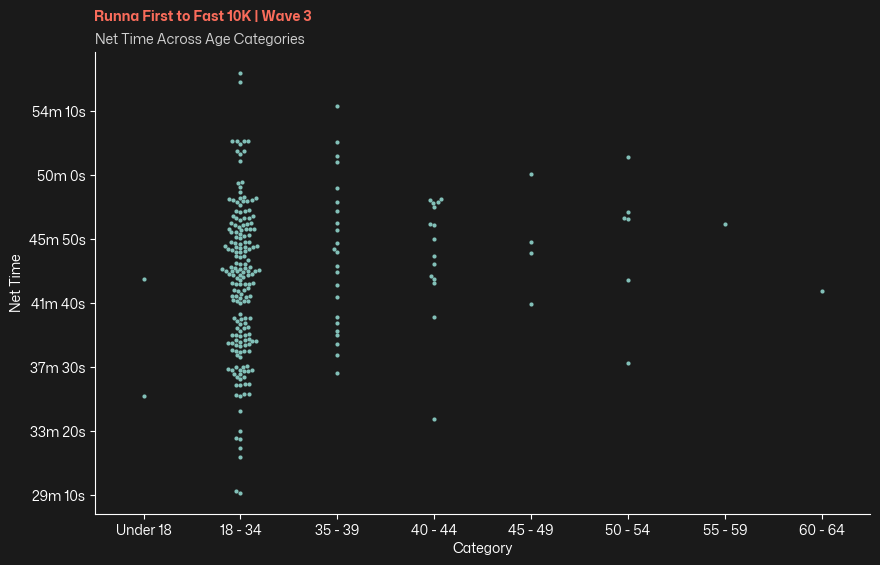

In [ ]:
# Create a swarm plot of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
# Define the desired order of categories
category_order = ['Under 18', '18 - 34', '35 - 39', '40 - 44', '45 - 49', '50 - 54', '55 - 59', '60 - 64']
sns.swarmplot(data=df_w3_clean, y='Net Time Seconds', x='Category', ax=ax, color='#82c0b8', size=3, order=category_order)

# Function to format seconds into minutes and seconds
def seconds_to_minutes_seconds(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f"{minutes}m {seconds}s"

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | Wave 3', x=0.233, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time Across Age Categories', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.ylabel('Net Time', color='white')
plt.xlabel('Category', color='white') # Remove x-axis label for swarm plot
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='x', colors='white')

# Apply the formatter to the y-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().yaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

plt.show()

### Histogram for 18 - 34 Age Category

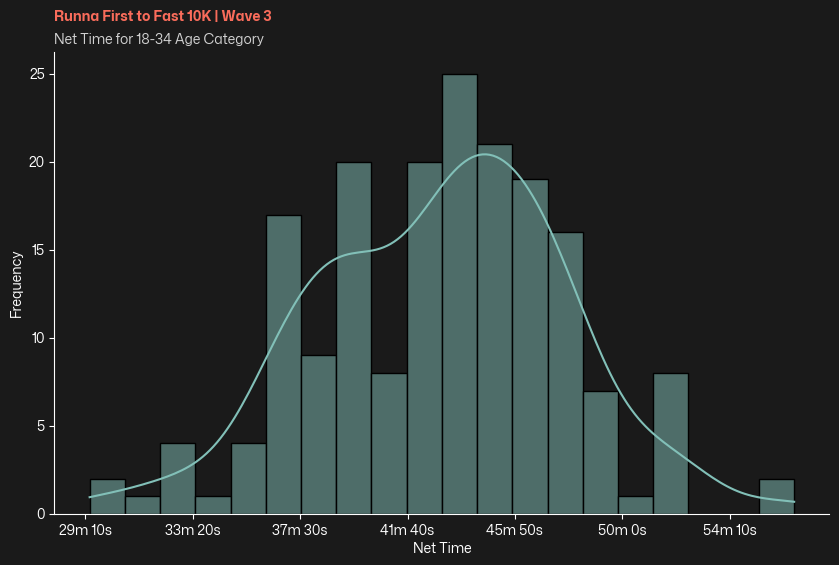

In [ ]:
# Filter the DataFrame for the '18 - 34' category
df_18_34_w3 = df_w3_clean[df_w3_clean['Category'] == '18 - 34'].copy()

# Create a histogram of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
sns.histplot(data=df_18_34_w3, x='Net Time Seconds', bins=20, kde=True, ax=ax, color='#82c0b8')

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | Wave 3', x=0.233, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time for 18-34 Age Category', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.xlabel('Net Time', color='white')
plt.ylabel('Frequency', color='white')
# plt.grid(axis='y', alpha=0.75) # Remove gridlines
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Apply the formatter to the x-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().xaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

plt.show()

## All Waves Analysis

Combining Data from All Waves and producing some visualisations

---

### Combine all data in Dataframe

In [ ]:
# Add a 'Wave No' column to each dataframe
df_w1_clean["Wave No"] = 'Wave 1'
df_w2_clean["Wave No"] = 'Wave 2'
df_w3_clean["Wave No"] = 'Wave 3'

df_all_clean = pd.concat([df_w1_clean, df_w2_clean, df_w3_clean], ignore_index=True)

# Convert 'Net Time' to timedelta objects
df_all_clean['Net Time'] = pd.to_timedelta(df_all_clean['Net Time'])

# Convert timedelta to total seconds
df_all_clean['Net Time Seconds'] = df_all_clean['Net Time'].dt.total_seconds()
df_all_clean.sort_values(by="Net Time Seconds", inplace=True)

# Reset index and show head
df_all_clean.reset_index(drop=True, inplace=True)
df_all_clean.head()

/tmp/ipython-input-3463671819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w1_clean["Wave No"] = 'Wave 1'


,Net Pos,Name,Net Time,Category,Net Time Seconds,Wave No
0,1.0,Joe Wigfield,0 days 00:29:20,18 - 34,1760.0,Wave 3
1,2.0,Jacob Allen,0 days 00:29:25,18 - 34,1765.0,Wave 3
2,3.0,Samuel Stevens,0 days 00:31:40,18 - 34,1900.0,Wave 3
3,4.0,Raif Serif,0 days 00:32:14,18 - 34,1934.0,Wave 3
4,5.0,Harry Tivnen,0 days 00:32:50,18 - 34,1970.0,Wave 3


### Table Visualisation for Summary Statistics

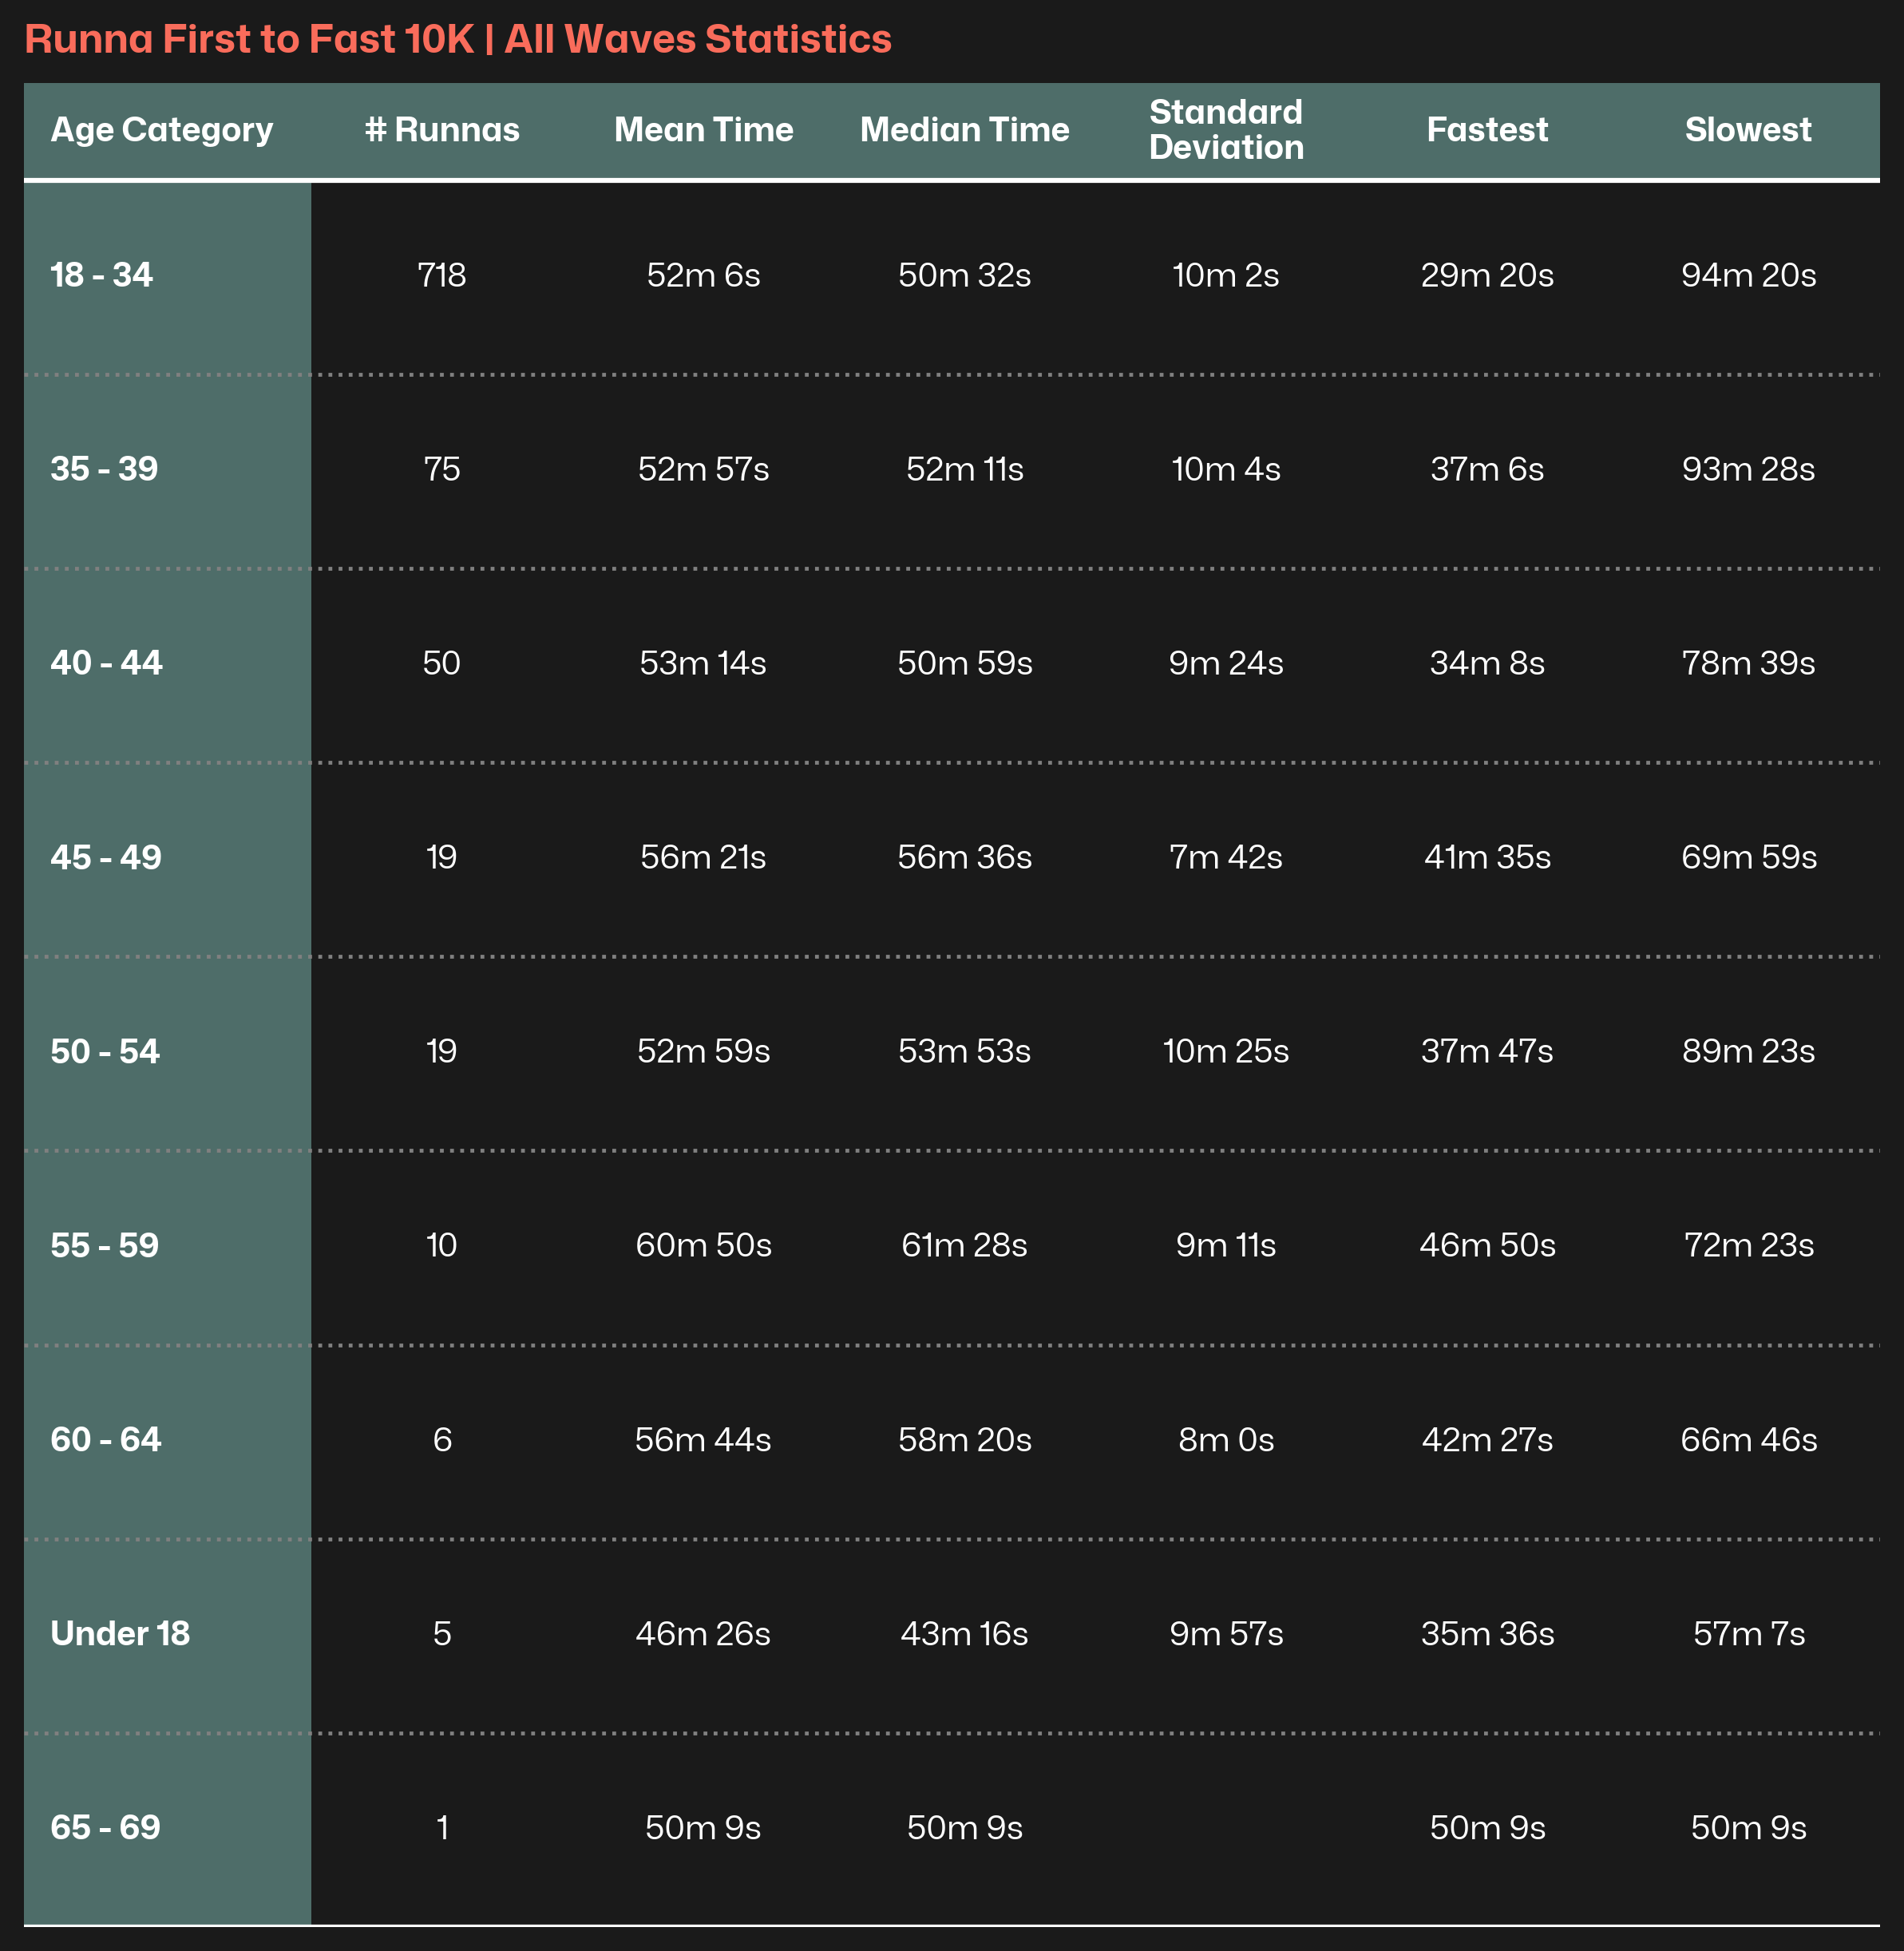

In [ ]:
# Calculate summary statistics for 'Net Time Seconds' by 'Category'
# Group the data by 'Category' and calculate count, mean, median, standard deviation, min, and max of 'Net Time Seconds'
summary_stats = df_all_clean.groupby('Category')['Net Time Seconds'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()

# Function to format seconds into minutes and seconds
def format_seconds_series(series):
    return series.apply(lambda x: f"{int(x // 60)}m {int(x % 60)}s" if pd.notnull(x) else '')

# Apply the time formatting function to the summary statistics columns
summary_stats['mean'] = format_seconds_series(summary_stats['mean'])
summary_stats['median'] = format_seconds_series(summary_stats['median'])
summary_stats['std'] = format_seconds_series(summary_stats['std'])
summary_stats['min'] = format_seconds_series(summary_stats['min'])
summary_stats['max'] = format_seconds_series(summary_stats['max'])
# Sort the summary statistics by the count of participants in each category
summary_stats.sort_values(by='count', inplace=True)

# Create a figure and axes for the table
fig = plt.figure(figsize=(10,10), dpi=300)
ax = plt.subplot()

# Define the number of columns and rows for the table
ncols = 7
nrows = summary_stats.shape[0]

# Set the limits for the axes to accommodate the table
ax.set_xlim(0, ncols + .1)
ax.set_ylim(0, nrows + .5)

# Define the positions for each column in the table
positions = [0.1, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
# Define the columns to display from the summary_stats DataFrame
columns = ['Category', 'count', 'mean', 'median', 'std', 'min', 'max']

# Set facecolor of the figure and axes
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')

# Add table's main text (data rows)
for i in range(nrows):
    for j, column in enumerate(columns):
        # Set horizontal alignment for the text
        if j == 0:
            ha = 'left'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to bold for the first column (Category)
            weight = 'bold'
            # Set font properties for the bold text
            font_properties = fm.FontProperties(fname=font_path_bold)
        else:
            ha = 'center'
            # Get the text label from the summary_stats DataFrame
            text_label = f'{summary_stats[column].iloc[i]}'
            # Set font weight to normal for other columns
            weight = 'normal'
            # Set font properties for the regular text
            font_properties = fm.FontProperties(fname=font_path_regular)
        # Add the text annotation to the plot
        ax.annotate(
            xy=(positions[j], i + .5), # Position of the annotation
            text=text_label, # The text to display
            ha=ha, # Horizontal alignment
            weight=weight, # Font weight
            va='center', # Vertical alignment
            color='white', # Set font color to white
            fontproperties=font_properties # Font properties
        )

# Add column names (header row)
column_names = ['Age Category', '# Runnas', 'Mean Time', 'Median Time', 'Standard\nDeviation', 'Fastest', 'Slowest']
for index, c in enumerate(column_names):
        # Set horizontal alignment for the column names
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        # Add the column name annotation to the plot
        ax.annotate(
            xy=(positions[index], nrows + .25), # Position of the annotation
            text=column_names[index], # The text to display (column name)
            ha=ha, # Horizontal alignment
            va='center', # Vertical alignment
            weight='bold', # Font weight for column names
            color='white', # Set font color to white
            fontproperties=fm.FontProperties(fname=font_path_bold) # Font properties for bold text
        )

# Add dividing lines to the table
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='white', marker='', zorder=4) # Top line
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='white', marker='', zorder=4) # Bottom line
# Add horizontal lines for each row
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

# Add shaded regions to the table
ax.fill_between(
    x=[0,1.1],
    y1=nrows,
    y2=0,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

ax.fill_between(
    x=[0,ncols + 0.1],
    y1=nrows + 1,
    y2=nrows,
    color='#82c0b8',
    alpha=0.5,
    ec='None'
)

# Add the title to the figure
fig.text(
    x=0.125, y=0.89,
    s='Runna First to Fast 10K | All Waves Statistics',
    ha='left',
    va='bottom',
    weight='bold',
    size=12,
    color='#f96c5b',
    fontproperties=fm.FontProperties(fname=font_path_bold)
)

# Turn off the axes
ax.set_axis_off()

### Strip Plot for All Age Categories

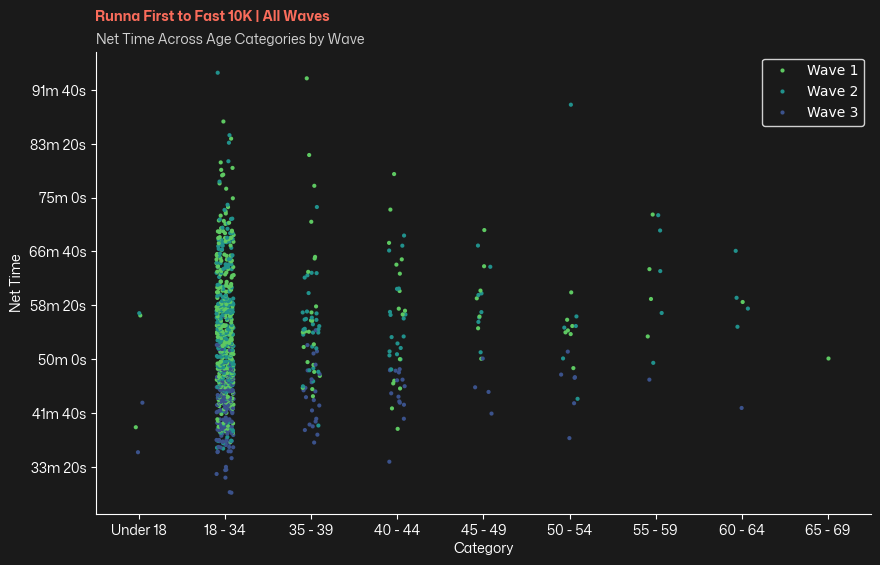

In [ ]:
# Create a stripplot of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
# Define the desired order of categories
category_order = ['Under 18', '18 - 34', '35 - 39', '40 - 44', '45 - 49', '50 - 54', '55 - 59', '60 - 64','65 - 69']
sns.stripplot(data=df_all_clean, y='Net Time Seconds', x='Category', ax=ax, size=3, order=category_order, hue='Wave No', palette='viridis', jitter=True)

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | All Waves', x=0.241, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time Across Age Categories by Wave', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.ylabel('Net Time', color='white')
plt.xlabel('Category', color='white') # Remove x-axis label for stripplot
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='x', colors='white')

# Apply the formatter to the y-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().yaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

# Add legend
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0] # Order for Wave 1, Wave 2, Wave 3
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper right', bbox_to_anchor=(1, 1), facecolor='#1a1a1a', edgecolor='white', labelcolor='white')

plt.show()

### Histogram for 18 - 34 Age Category

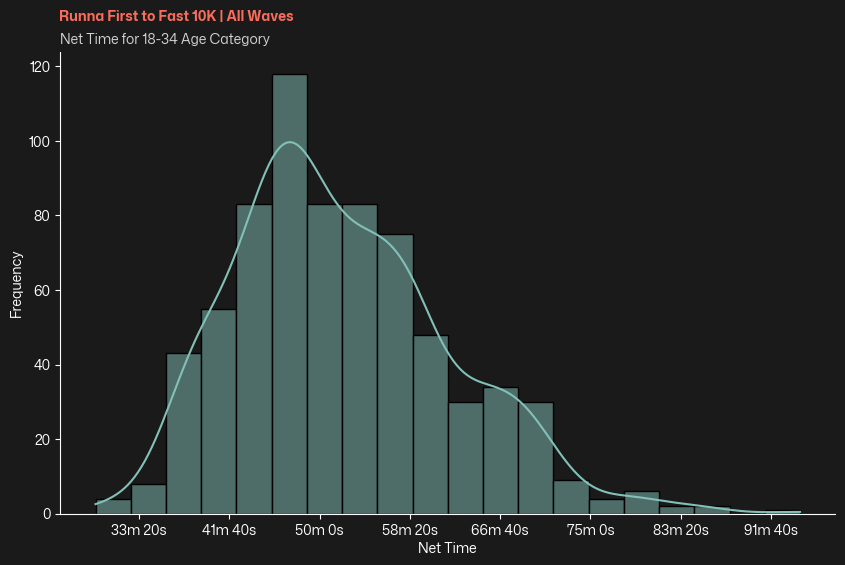

In [ ]:
# Filter the DataFrame for the '18 - 34' category
df_18_34_all = df_all_clean[df_all_clean['Category'] == '18 - 34'].copy()

# Create a histogram of 'Net Time Seconds' for the filtered data
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')
sns.histplot(data=df_18_34_all, x='Net Time Seconds', bins=20, kde=True, ax=ax, color='#82c0b8')

# Set the suptitle and title with font properties
plt.suptitle('Runna First to Fast 10K | All Waves', x=0.241, y=0.95, fontproperties=fm.FontProperties(fname=font_path_bold), color='#f96c5b')
plt.title('Net Time for 18-34 Age Category', loc="left", fontproperties=fm.FontProperties(fname=font_path_regular), color='#d1d1d1')

plt.xlabel('Net Time', color='white')
plt.ylabel('Frequency', color='white')
# plt.grid(axis='y', alpha=0.75) # Remove gridlines
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border
plt.gca().spines['bottom'].set_edgecolor('white')
plt.gca().spines['left'].set_edgecolor('white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Apply the formatter to the x-axis
formatter = mticker.FuncFormatter(seconds_to_minutes_seconds)
plt.gca().xaxis.set_major_formatter(formatter)
plt.setp(plt.gca().get_xticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.setp(plt.gca().get_yticklabels(), fontproperties=fm.FontProperties(fname=font_path_regular), color='white')
plt.gca().xaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))
plt.gca().yaxis.label.set_fontproperties(fm.FontProperties(fname=font_path_regular))

plt.show()